In [1]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import torch.nn
from scvi.distributions import NegativeBinomial
from typing import Optional
from anndata import AnnData
import scvi
from scvi.data import AnnDataManager
from scvi.data.fields import(
    LayerField, 
    CategoricalObsField,
    NumericalObsField,
    CategoricalJointObsField,
    NumericalJointObsField,
)
from scvi import REGISTRY_KEYS
from scvi.module.base import (
    BaseModuleClass,
    LossRecorder,
    auto_move_data,
)
from scvi.model.base import BaseModelClass, UnsupervisedTrainingMixin

sc.set_figure_params(figsize=(4, 4))

Global seed set to 0


I will be randomly generating data for now - this data follows a ZINB distribution

## Data Loading

In [2]:
adata = scvi.data.synthetic_iid()

anndata_fields = [
    LayerField(registry_key="x", layer=None, is_count_data=True),
    CategoricalObsField(registry_key="batch", obs_key="batch"),
]
adata_manager = AnnDataManager(fields=anndata_fields)
adata_manager.register_fields(adata)
print(adata_manager.registry.keys()) # There is additionally a _scvi_uuid key which is used to uniquely identify AnnData objects for subsequent retrieval.

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scvi/data/_built_in_data/_synthetic.py:28: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(data)


dict_keys(['scvi_version', 'model_name', 'setup_args', 'field_registries', '_scvi_uuid'])


In [3]:
adata

AnnData object with n_obs × n_vars = 400 × 100
    obs: 'batch', 'labels', '_scvi_batch'
    uns: 'protein_names', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'protein_expression'

## Probabilistic Model

For now, I am exclusively interested in an inferential task. I'll build up a generative model later by making assumptions about the distribution of these parameters. But for now, I will assume no variation in cell state. The gene expression of a gene $g$ in a cell $n$, $x_{ng}$, is then:
$$ x_{ng} \sim \textrm{NegativeBinomial} (l_n \mu_g, \theta_g)$$

Where $\mu_g$ and $\theta_g$ are positive parameters to be learned (the mean and dispersion parameters of the negative binomial distribution).

### Inference mechanism

We can use maximum likelihood estimation to perform inference over the parameters $\Theta=\{ \mu_g, \theta_g \}$. To do so we inherit from the base module class, and create a negative binomial model with a loss function that's just the negative log likelihood. We assume no generative model.

In [5]:
class NB_Module(BaseModuleClass):
    """
    Basic negative binomial model.

    Parameters
    ----------
    n_input
        Number of input genes
    """

    def __init__(
        self,
        n_input: int
    ):
        super().__init__()
        # in the init, we create the parameters of our elementary stochastic computation unit.

        # First, we setup the parameters of the generative model
        self.log_mu = torch.nn.Parameter(torch.randn(n_input))
        self.log_theta = torch.nn.Parameter(torch.randn(n_input))

    def _get_inference_input(self, tensors):
        return dict()
    
    def _get_generative_input(self, tensors, inference_outputs):
        x = tensors[REGISTRY_KEYS.X_KEY]
        # here we extract the number of UMIs per cell as a known quantity
        library = torch.sum(x, dim=1, keepdim=True)

        input_dict = {
            "library": library,
        }
        return input_dict

    def inference(self):
        return dict()
        
    @auto_move_data
    def generative(self, library):
        """Runs the generative model."""

        # get the mean parameter of the negative binomial
        mu = library * torch.exp(self.log_mu)
        # get the dispersion parameter
        theta = torch.exp(self.log_theta)

        return dict(
            mu=mu, theta=theta
        )

    def loss(
        self,
        tensors,
        inference_outputs,
        generative_outputs,
    ):

        # here, we would like to form the log likelihood
        # so we extract all the required information
        x = tensors[REGISTRY_KEYS.X_KEY]
        mu = generative_outputs["mu"]
        theta = generative_outputs["theta"]

        # log likelihood
        # note that I'm using the scVI NB which offers this mu/ theta parametrization, compatible with the Poisson-Gamma 
        log_lik = NegativeBinomial(mu=mu, theta=theta).log_prob(x).sum(dim=-1)

        nll = torch.mean(-log_lik)
        return LossRecorder(loss=nll, reconstruction_loss=-log_lik)

## Training

To train the model, I will inherit from the base model class and the unsupervised training mixin class.

In [6]:
class NB_Model(UnsupervisedTrainingMixin, BaseModelClass):
    def __init__(
        self,
        adata: AnnData,
        **model_kwargs,
    ):
        super(NB_Model, self).__init__(adata)

        self.module = NB_Module(
            n_input=self.summary_stats["n_vars"],
            **model_kwargs,
        )
        self._model_summary_string = ("NB Model has been created")
        self.init_params_ = self._get_init_params(locals())

    @classmethod
    def setup_anndata(
        cls,
        adata: AnnData,
        batch_key: Optional[str] = None,
        layer: Optional[str] = None,
        **kwargs,
    ) -> Optional[AnnData]:
        setup_method_args = cls._get_setup_method_args(**locals())
        anndata_fields = [
            LayerField(REGISTRY_KEYS.X_KEY, layer, is_count_data=True),
            CategoricalObsField(REGISTRY_KEYS.BATCH_KEY, batch_key),
            # Dummy fields required for VAE class.
            CategoricalObsField(REGISTRY_KEYS.LABELS_KEY, None),
            NumericalObsField(
                REGISTRY_KEYS.SIZE_FACTOR_KEY, None, required=False
            ),
            CategoricalJointObsField(
                REGISTRY_KEYS.CAT_COVS_KEY, None
            ),
            NumericalJointObsField(
                REGISTRY_KEYS.CONT_COVS_KEY, None
            ),
        ]
        adata_manager = AnnDataManager(
            fields=anndata_fields, setup_method_args=setup_method_args
        )
        adata_manager.register_fields(adata, **kwargs)
        cls.register_manager(adata_manager)

In [7]:
NB_Model.setup_anndata(adata, batch_key="batch")
my_model = NB_Model(adata)

In [8]:
my_model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:07<00:00, 52.12it/s, loss=508, v_num=1]


Check whether the parameters are what we'd expect them to be

In [9]:
empirical_libsizes = np.reshape(np.sum(adata.X, axis=1), (adata.shape[0], 1))

In [10]:
empirical_means = np.mean(np.divide(adata.X, empirical_libsizes), axis=0)

In [11]:
model_means = torch.exp(my_model.module.log_mu).cpu().detach().numpy()

In [12]:
empirical_means

array([0.01010271, 0.00949435, 0.01122496, 0.00979518, 0.01028525,
       0.01006608, 0.00976085, 0.00976443, 0.009719  , 0.0104483 ,
       0.01050898, 0.01017805, 0.0095544 , 0.00886288, 0.00989365,
       0.01021235, 0.01038063, 0.010628  , 0.0102234 , 0.01008236,
       0.01046244, 0.0103889 , 0.00979643, 0.00998066, 0.01004249,
       0.00924469, 0.01060446, 0.01051587, 0.0099667 , 0.0098655 ,
       0.00990636, 0.00995202, 0.00937541, 0.01042818, 0.00875999,
       0.00971607, 0.00930393, 0.00964822, 0.01023766, 0.00941563,
       0.01001425, 0.00950833, 0.00996635, 0.01029989, 0.01000723,
       0.01047107, 0.00991597, 0.00965965, 0.0096276 , 0.01063732,
       0.01117498, 0.01010625, 0.01006703, 0.00981892, 0.01018743,
       0.00982588, 0.01055755, 0.0102737 , 0.00924832, 0.01041131,
       0.01057354, 0.00865247, 0.01006649, 0.00913697, 0.0095797 ,
       0.01018686, 0.01017576, 0.01007109, 0.00954831, 0.00941061,
       0.00975159, 0.01052397, 0.01084445, 0.01033085, 0.01007

Not sure why these don't match better, did the negative log likelihood reach a flatline?

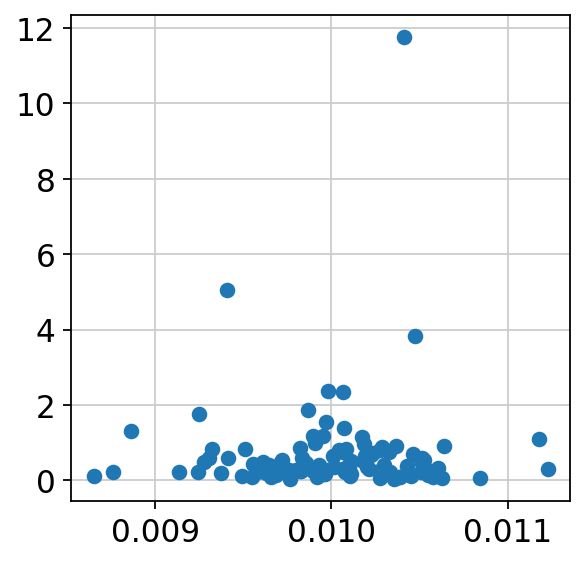

In [13]:
plt.plot(empirical_means, model_means, 'o')

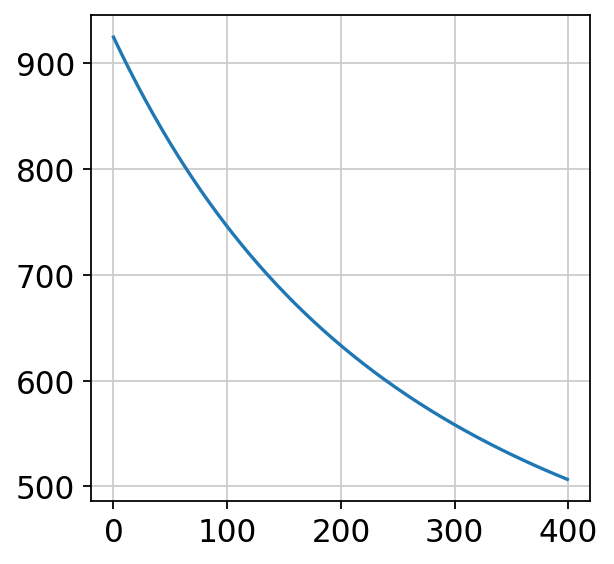

In [14]:
plt.plot(my_model.history_['train_loss_epoch'])

It did not. Would initializing to the correct means make things better?

In [101]:
log_mu_init = np.log(empirical_means)

In [ ]:
NB_Model.setup_anndata(adata, batch_key="batch")
my_model_initialized = NB_Model(adata)

In [ ]:
Save 